### **Quick introduction to jupyter notebooks**
* Each cell in this notebook contains either code or text.
* You can run a cell by pressing Ctrl-Enter, or run and advance to the next cell with Shift-Enter.
* Code cells will print their output, including images, below the cell. Running it again deletes the previous output, so be careful if you want to save some results.
* You don't have to rerun all cells to test changes, just rerun the cell you have made changes to. Some exceptions might apply, for example if you overwrite variables from previous cells, but in general this will work.
* If all else fails, use the "Kernel" menu and select "Restart Kernel and Clear All Output". You can also use this menu to run all cells.
* A useful debug tool is the console. You can right-click anywhere in the notebook and select "New console for notebook". This opens a python console which shares the environment with the notebook, which let's you easily print variables or test commands.

### **Setup**

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from scipy import io as sio

from utils import GenerateHaarFeatureMasks, GenerateTrainTestData, ExtractHaarFeatures
from utils import PlotErrorGraphs, PlotClassifications, PlotSelectedHaarFeatures, PlotHaarFeatureDemonstration, PlotSolvayHeatmap
plt.rcParams['figure.facecolor']='white'

# Load data
faces = sio.loadmat('Data/faces.mat')['faces'].astype("float")
nonfaces = sio.loadmat('Data/nonfaces.mat')['nonfaces'].astype("float")

### ***! IMPORTANT NOTE !***

Your implementation should only use the numpy module (already imported as np). The numpy module provides all the functionality you need for this assignment and makes easier debuging your code. No other modules, e.g. scikit-learn or scipy among others, are allowed and solutions using modules other than the numpy module will be sent for re-submission.

---
### **1 Introduction**
In this assignment you will explore a branch of supervised learning called *Ensemble lerning*, specifically using the algorithm known as *AdaBoost*. This algorithm trains multiple simple *weak classifiers* that are later combined into a *strong classifier* which is significantly more powerful than the individual *weak classifiers*. The *weak classifier* you will work with is a simple type of binary classifier called decision stump. These classify scalar inputs based on a single comparisson with a threshold.

![](NotebookMaterials/DecisionStump.png "Decision stump")

In order to apply this classifier to images, we require a way to describe the features of the images using a single number that the decision stump can compare to the threshold. In a seminal article by Viola and Jones, called [Robust real-time object detection](https://www.researchgate.net/publication/215721846_Robust_Real-Time_Object_Detection), this was demonstrated using so called Haar-features, which is what we will use in this assignment.

A Haar-feature is a simple yet surprisingly effective way to quantify edges and gradients in images, by computing the weighted sum of different areas of the image. We will begin by exploring how these Haar-features work, in order to understand the fundamental building blocks of the algorithm you will implement later.

Run the following code cell to generate a random Haar-feature, select a random face and nonface image, and compute the feature values by applying the Haar-feature to the images.

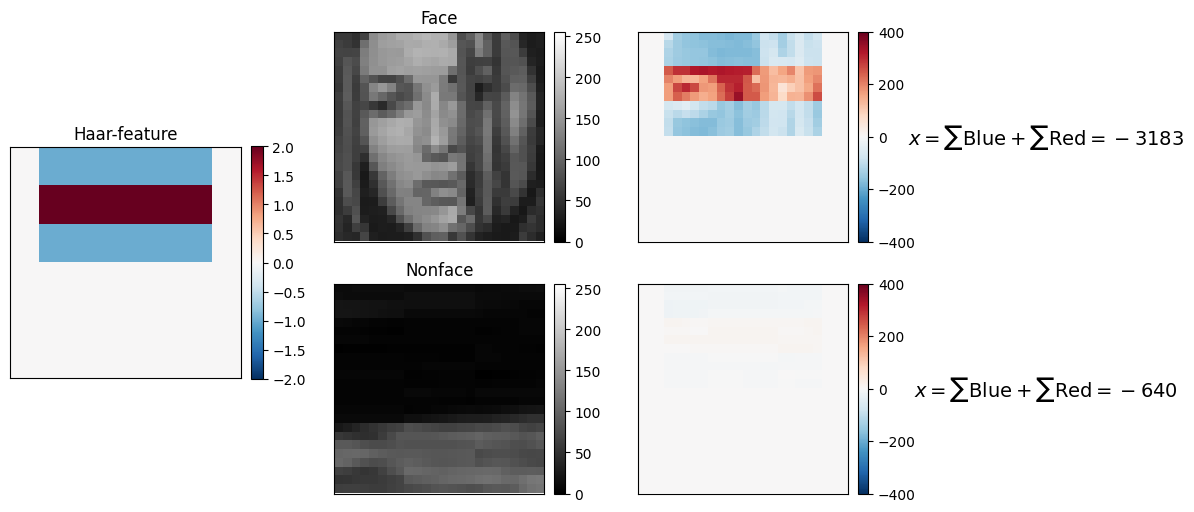

In [2]:
# Generate random Haar-feature and select a random face and a random non-face
randomHaarFeatureMask = GenerateHaarFeatureMasks(1)[:,:,0]
randomFace = faces[:,:,np.random.randint(faces.shape[2])]
randomNonFace = nonfaces[:,:,np.random.randint(nonfaces.shape[2])]

PlotHaarFeatureDemonstration(haar=randomHaarFeatureMask, face=randomFace, nonface=randomNonFace)

The Haar-features we generate in this assignment consist of either two or three areas, each with a scaling factor of -1, 1, or 2. The pixels outside the Haar-feature has a scaling of 0. The images are pixel-wise multiplied with the Haar-feature, after which the entire image is summed to a single scalar value. This weighted sum of pixels is the feature value of the image, which can be used in the weak classifier.

Of course, since the Haar-feature in this picture is chosen entierly at random, we should not expect that it makes sense as a good feature extractor. Finding a good set of Haar-features is your task, but we will get back to that soon. Before that, take a look at the decision stump classifier again. Now that we know how to extract a single feature value from an image, we can see how a desision stump can be used to classify the images as faces or nonfaces. We can write the decision stump as a function:

$$
\large
f(x \: | \: \tau) =
\begin{cases}
    +1 & \text{if } x \geq \tau \\
    -1 & \text{if } x < \tau
\end{cases}
$$

As you have already seen in the lecture on boosting and ensemble learning, this can also be extended to a more general definition by including a polarity parameter:

$$
\large
f(x \: | \: \tau, p) =
\begin{cases}
    +1 & \text{if } px \geq p\tau \\
    -1 & \text{if } px < p\tau
\end{cases}
$$

By selecting $p$ equal to +1 or -1, we can flip the sign of the predicted output. Since this is a binary classification, this also changes the error of the classifier from $e$ to $1-e$. This is necessary if we want to guarantee that we can find the optimal classifier.

#### **1.1 Generating the training data**
Since a single random Haar-feature is unlikely to be a good feature extractor, we need to generate a large number of them and find the ones that are useful. But extracting the feature values from the images during training is very inefficient, so instead we precompute the feature value for each Haar-feature applied on each image. This will therefore result in a feature value matrix $X^{[R,C]}$ (i.e. $R$ rows and $C$ columns), where $R$ is the number of Haar-feature and $C$ is the number of images in the dataset, as illustrated in this picture:

![](NotebookMaterials/HaarExtractionDemo.png "Precomputing feature values")

Note that the training loop will only work with this matrix, never with the original images or Haar-features.

#### **1.2 The AdaBoost algorithm**
AdaBoost is an ensemble learning algorithm that successively trains many weak classifiers that are informed about the weaknesses of the previous classifiers. This is done by keeping track of a weight value $d$ for each training image, representing how "difficult" that image has been to classify during training so far. After a weak classifier has been trained, the predictions of that classifier is used to update the weights of all images. If an image was classified correctly the weight is exponentially decreased, and the next weak classifier will therefore put less emphasis on that sample since it is already taken care of by the previous weak classifiers. The weights of misclassifed images are instead exponentially increased to make them more important for the next weak classifier.

In more detail, if a weak classifier results in an error $\varepsilon$, we compute the update factor

$$\large \alpha = \frac{1}{2} \mathrm{ln}\left( \frac{1-\varepsilon}{\varepsilon} \right)$$

and then update the weights according to

$$\large d_{t+1} = \begin{cases} d_t e^{-\alpha} & \text{if correctly classified} \\ d_t e^{\alpha} & \text{if misclassified} \end{cases}$$

We also normalize $d_{t+1}$ such that the total weight of all samples is 1. The next weak classifier is then trained using the new weights $d_{t+1}$, which will put the focus on missclassified images and therefore result in a new combination of optimal parameters. This is how AdaBoost gradually covers more and more of the difficult cases in the data, even thought the same training images and Haar-feature are used for each weak classifier.

When the training of all weak classifiers is finished we use them in a weighted voting scheme to build the *strong classifier*.

$$\large H(x) = \mathrm{sign} \left( \sum_{t=1}^{T} \alpha_t h_t(x) \right)$$

Note that we use the update factor $\alpha$ for each weak classifier as a weight in the voting. This is because weak classifiers with lower total error should have more voting power to increase the overall performance of the strong classifier.

#### **<span style="color:red">Question 1:</span>**
The error of a single weak classifier is always in the range 0 to 0.5 (since we otherwise flip the polarity). Consider the two edge cases:
1. If you get an optimal $\varepsilon = 0$ this single weak classifier correctly predicted the entire training set. What does this indicate about your hyperparameters (number of Haar-features, number of training images, number of weak classifiers)?
2. If you get an optimal $\varepsilon = 0.5$ the training will get stuck. Explain why this is the case.

#### **<span style="color:green">Answer:</span>**
1.⁠ ⁠Number of Haar-features: Having a larger number of Haar features increases the diversity of features available for training the weak classifier. If a weak classifier achieves perfect prediction with a relatively small number of Haar features, it suggests that the features selected are highly informative and sufficient for the implementation.

Number of Training Images: Having a sufficient number of diverse training images helps the weak classifier to learn robust patterns from the data. If a weak classifier achieves perfect prediction with a limited number of training images, it indicates that the classifier is able to map the underlying pattern from the dataset. Thus, the training images represents the underlying patterns of the dataset.

Number of Weak Classifiers: Achieving perfect prediction with a single weak classifier suggests that the task may not be very complex, and additional weak classifiers may not significantly improve the overall performance. However, adding more weak classifiers can potentially lead to overfitting if the weak classifiers start memorizing noise in the training data

2. If a single weak classifier achieves an optimal weighted error (E) of 0.5, it means that the weak classifier's performance is no better than random guessing. In this case, the AdaBoost algorithm will get stuck because it relies on the weak classifiers to perform better than random guessing. When a weak classifier consistently predicts incorrectly (i.e., has an error of 0.5), the subsequent iterations of boosting will not be able to improve upon this performance significantly. This happens because AdaBoost assigns higher weights to misclassified samples, and if a weak classifier consistently misclassifies samples, it will continue to receive higher weights, making it difficult for subsequent weak classifiers to correct these errors. As a result, the algorithm may not be able to find a sequence of weak classifiers that collectively improve the overall performance, leading to a situation where the training process gets stuck.

#### **1.3 Pseudo-code**
With all this in mind, we can summarize the entire algorithm in the following pseudo-code:

`TrainWeakClassifier:`<br>
>`for every combination of (feature, threshold, polarity):`<br>
>> `Run WeakClassifier`<br>
>> `Measure error`<br>
>> `if new smallest error:`<br>
>>> `Save parameters`<br>
>
> `return optimal parameters`

<br>

`TrainStrongClassifer:`<br>
> `Initialize weights for each training sample`<br>
> `for number of weak classifiers:`<br>
>> `TrainWeakClassifier`<br>
>> `Measure error and get predictions`<br>
>> `Compute update parameter alpha`<br>
>> `Update training sample weights`<br>
>
>`return optimal parameters`


---
### **2. Implementing the weak classifier**

You will now start by implementing the decision stump weak classifier, the weighted error function, and the training loop for a single weak classifier.

#### **2.1 Weak classifier forward function**

The forward function classifies the data according to the threshold and polarity.

In [3]:
# Implement decision stump classifier
# X - Feature values (vector)
# t - Threshold (scalar)
# p - Polarity (1 or -1)
# Return a vector of predicted classes (1 or -1), same shape as X.

def WeakClassifier(X,t,p):
    return np.where(p * X < p * t, -1, 1)

#### **2.2 Weighted classification error**

This function computes the weighted classification error based on predicted and true classes, as well as the weight vector.

In [4]:
# Implement error function
# Y  - Target classes (vector)
# Yp - Predicted classes (vector)
# D  - Weights (vector)
# Return a scalar for the total weighted error of all predictions.

def WeakClassifierError(Y,Yp,D):
    return np.sum(D * ( Y != Yp))

#### **2.3 Training function for a single weak classifier**

Here you should implement the training of a single weak classifier, using the two functions you just implemented. Based on the training data, sample weights, and target labels, find the optimal way to separate the two classes. You should do this using brute force search, in other words, try every (reasonable) combination of parameters, measure the errors, and pick the best. Return all parameters that define the optimal weak classifier, as well as the error of said weak classifier.

*Tip: Brute force search is not an efficient algorithm, so any optimization you can do is welcome. When you have a working version of this function, consider if there is any way you can decrease the amount of calls to WeakClassifier, especially by reducing the number of thresholds. Of course, you must still guarantee that you can find the optimal parameters, so for example naively discarding every other threshold will not work.*

In [5]:
# Implement function for training one decision stump
# X - Training data (matrix)
# Y - Target classes (vector)
# D - Error weights (vector)
# Return optimal feature, threshold, polarity, and the corresponding error

def TrainWeakClassifier(X,Y,D):
    
    fOpt = None
    tOpt = None
    pOpt = None
    eMin = np.inf
    for feature in range(X.shape[0]): 
        thresholds = np.unique(X[feature, :])
        for threshold in thresholds:
            for polarity in [-1, 1]:
                Y_predicted = WeakClassifier(X[feature, :], threshold, polarity)
                error = WeakClassifierError(Y, Y_predicted, D)
                if error < eMin :
                    eMin = error
                    fOpt = feature
                    tOpt = threshold
                    pOpt = polarity
            
    return fOpt, tOpt, pOpt, eMin

Test your implementation by running the following minimal test case. You should find that the optimal feature is 1 (remember that python is 0-indexed!), the optimal threshold is between 1 and 3 (depending on your implementation), and the optimal polarity is -1. The minimum error should be 0.222 repeating.

In [6]:
X = np.array([[2, 2, 2, 2, 2, 3], [3, 3, 3, 1, 1, 4], [4, 2, 4, 2, 4, 2]])
Y = np.array([-1,-1, -1, 1, 1, 1])
D = np.array([1,1,1,2,2,2]) / 9

fOpt, tOpt, pOpt, eMin = TrainWeakClassifier(X,Y,D)
print(f"Optimal feature   : {fOpt}")
print(f"Optimal threshold : {tOpt}")
print(f"Optimal polarity  : {pOpt}")
print(f"Minumum error     : {eMin}")

Optimal feature   : 1
Optimal threshold : 1
Optimal polarity  : -1
Minumum error     : 0.2222222222222222


---
### **3. Implementing the strong classifier**
You should now implement the main AdaBoost algorithm, using the training function for weak classifiers you just implemented. Return the optimal parameters for all weak classifiers. We have given you some boilerplate code here to help you get started, and to provide some useful outputs during the training.

In [7]:
from time import perf_counter as tic
from datetime import timedelta

# Implement AdaBoost training
# X - Training data (matrix)
# Y - Target classes (vector)
# N - Number of weak classifiers to train (scalar)
# Return the optimal features, thresholds, polarities, and alphas describing the N weak classifiers

def TrainStrongClassifier(X,Y,N=10):
    
    fOpt = np.zeros(N,"int")
    tOpt = np.zeros(N)
    pOpt = np.zeros(N)
    aOpt = np.zeros(N)
    
    # Initialize sample weights here
    num_samples = X.shape[1]
    D = np.ones(num_samples) / num_samples
    
    timeStart = tic()
    
    for n in range(N):
        fOpt[n], tOpt[n], pOpt[n], eMin = TrainWeakClassifier(X, Y, D)  # Train weak classifier
        Yp = WeakClassifier(X[fOpt[n], :], tOpt[n], pOpt[n])  # Get prediction
        aOpt[n] = 0.5 * np.log((1 - eMin) / (eMin + 1e-10))  # Compute alpha
        D *= np.exp(-aOpt[n] * Y * Yp)  # Update weights
        D /= np.sum(D)  # Normalize weights
        
        # This prints the training progress in a nice format
        timeLeft = round((tic() - timeStart) * (N / (n + 1) - 1))
        etaStr = str(timedelta(seconds=timeLeft))
        print(f"{n + 1} of {N}: ETA {etaStr}    ", end="\r")
    
    return fOpt, tOpt, pOpt, aOpt

Finally, you should implement the StrongClassifier function. This function takes in the parameters returned from the training function and classifies the input $X$. If input $Y$ is also provided, the error of the strong classifier should also be computed and returned.

Additionally, it is interesting to evaluate the strong classifier not only on the final ensemble model, but how the performance improved during the training, as more and more weak classifiers were added. As such, the error returned from this function should be a vector with the same lenght as the number of weak classifiers. The first value in the vector should only use the first weak classifier. The second value should use the first two classifiers in the ensemble, and so on. In general, the n:th entry is the error when using the first n weak classifiers as a strong classifier. This way we can plot the performance as a function of number of weak classifiers, which is important to investigate, for example, overfitting.

*Tip: There is a function in numpy called* `cumsum`*, which stands for cumulative sum. It is not mandatory to use this, but the code for computing the error vector can be very short if you do.*

In [8]:
# Implement strong classifier
# Params - Parameters of the weak classifiers (output from AdaBoost training function)
# X - Data to classify (matrix)
# Y - Target labels (vector). Optional input, see text description above.
# Return predicted classes (vector) and optionally the error (vector).

def StrongClassifier(Params, X, Y=None):
    
    fOpt, tOpt, pOpt, aOpt = Params
    weak_classifiers = len(fOpt)
    num_samples = X.shape[1]
    H = np.zeros(num_samples)
    Err = np.zeros(weak_classifiers)

    for n in range(weak_classifiers):
        Yp = WeakClassifier(X[fOpt[n], :], tOpt[n], pOpt[n])
        H += aOpt[n] * Yp

        if Y is not None:
            Err[n] = np.sum((np.sign(H) != Y) * (1 / num_samples))

    H = np.sign(H)

    if Y is not None:
        return H, Err
    else:
        return H

---
### **4. Training and evaluating the model**
Now you will run the AdaBoost training and evaluate the results. We have provided all required code for plotting the results, but if there are additional results you wish to show you are welcome to make your own plots as well.

The following cell generates a set of random Haar-features, then precomputes the feature values and splits the data into a training set and a test set. Change the three hyperparamters; number of Haar-features, number of training samples, and number of weak classifiers to obtain the target performance 7% error or lower. Of course the error should be stable below the target as well.

In [12]:
# Generate Haar feature masks
haarFeatureMasks = GenerateHaarFeatureMasks(nbrHaarFeatures = 100)

# Extract feature values and split into training and test sets
trainImages, testImages, XTrain, YTrain, XTest, YTest = GenerateTrainTestData(faces, nonfaces, haarFeatureMasks, nbrTrainImages = 1000)
# Train the classifier
optParams = TrainStrongClassifier(XTrain, YTrain, N = 100)

Now evaluate your classifier on the training data and test data.

In [13]:
HTrain, ErrTrain = StrongClassifier(optParams, XTrain, Y = YTrain)
HTest , ErrTest  = StrongClassifier(optParams, XTest , Y = YTest)

ErrTrain *= 100
ErrTest  *= 100

print(f"Training error: {ErrTrain[-1]:.1f}%")
print(f"Test error: {ErrTest[-1]:.1f}%")

Training error: 0.0%
Test error: 7.3%


Plot the error of the strong classifier as a function of the number of weak classifiers.

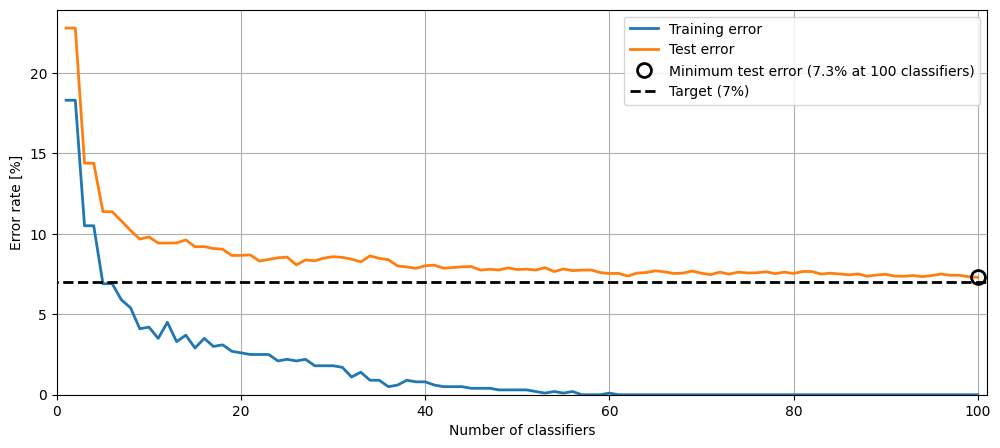

In [14]:
PlotErrorGraphs(ErrTrain, ErrTest)

#### **<span style="color:red">Question 2:</span>**
Suppose you want to deploy your model in a real-world application, for example in a smartphone camera app that can highlight faces. Based on the above result, how many weak classifiers would you choose to include in the model? Motivate your answer.

#### **<span style="color:green">Answer:</span>**
From the above results we can see that for 100 Haar features, I am able to achive good accuracy for with 100 Week classifier, To deploy the model in real life applications, we need to consider many parameters such as the computation power of the device and Reat time face detection. So I would like to have the weak classifier not more than 100 in number, as it will increase the computation time along, Thus delay the response, which will be a negative point in terms of the real life scenario.

#### **<span style="color:red">Question 3:</span>**
Discuss your choise of hyperparameters
* number of training images
* number of Haar-features
* number of weak classifiers

and how each affect the model performance. What are the advantages and disadvantages to low and high values for each parameter?

#### **<span style="color:green">Answer:</span>**
We have started with the 50 Haar feature, with 500 training images and 50 weak classifier, But I am not able to achieve the results. So, We have increased the number of Haar features to 100, training images to 1000, and the number of weak classifier to 100, By this we are able to achieve the results.
- number of training images : Increasing and decreasing the number of training images will affect the training time along with the computation power of theclassifier, If the training images are very low, then it may evenoverfit the model, by memorizing the important features and setting up the weights against them large. Thus, a good amount of training images are needed for the classifier to perform at reasonable amount of accuracy.
- number of Haar-features : As we will increase the amount of Haar-features used in the Training, I will say that it will affect the training and computation time of the Network, It might be slow, But as the more haar features represents more informations, It will give us a good accuracy.
- number of weak classifiers: Increasing and decreasing the number of weak classifier, will affect the training time and classification power of the classifier, as very low number of weak classifier, will not be able to classify the complex structure of the object. Thus, reduces the accuracy. Whereas a large number of weak classifier will make the training slow, as the training time for them will increase and they will be needed more computation power. Thus, These hyperparameters are depended on each other, more relatable values for these hyperparameter will give us a good classifier.

#### **4.1 Investigate the trained model**
Plot some examples of faces and nonfaces that were classified correctly and that were misclassified. To do this, we requre you to find the index in the test data of these four cases:
* Faces classified as faces (F_F)
* Faces classified as nonfaces (F_NF)
* Nonfaces classified as faces (NF_F)
* Nonfaces classified as nonfaces (NF_NF)

There are many ways to do this. It is possible to write each in a single line using numpy functions, although this is not required.

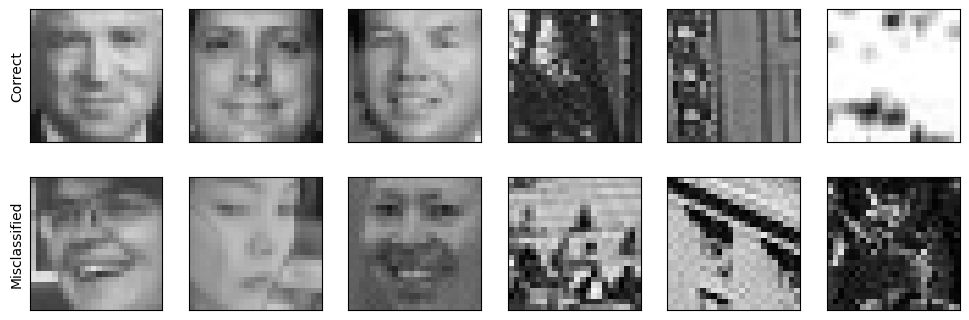

In [13]:
F_F   = np.where((HTest == 1) & (YTest == 1))[0]
F_NF  = np.where((HTest == -1) & (YTest == 1))[0]
NF_F  = np.where((HTest == 1) & (YTest == -1))[0]
NF_NF = np.where((HTest == -1) & (YTest == -1))[0]

PlotClassifications(testImages, F_F, F_NF, NF_NF, NF_F, N=3, selectRandom=True)

#### **<span style="color:red">Question 4:</span>**
Run the above cell a few times and discuss some potential issues in the data that might explain these misclassified images. Can you think of any pre-processing that might improve the results?

#### **<span style="color:green">Answer:</span>**
After running the above code a few time, Their might be a few potential issues, a few of which we can realise are different pose and oriantation, Low quality images, Background overlaping, lighting on the faces. we can use dimentianal reduction(PCA) or CNN to get the images in low dimension, or may be coloured images, so it will be easy to classify the background and the faces,Normalization of the images, so if a image has different oriantation or different position in the whole image, It can fix and all images are in same places.

Run the following code to plot (some) of your selected Haar-features. Feel free to change the paramters `shuffle` and `N`.

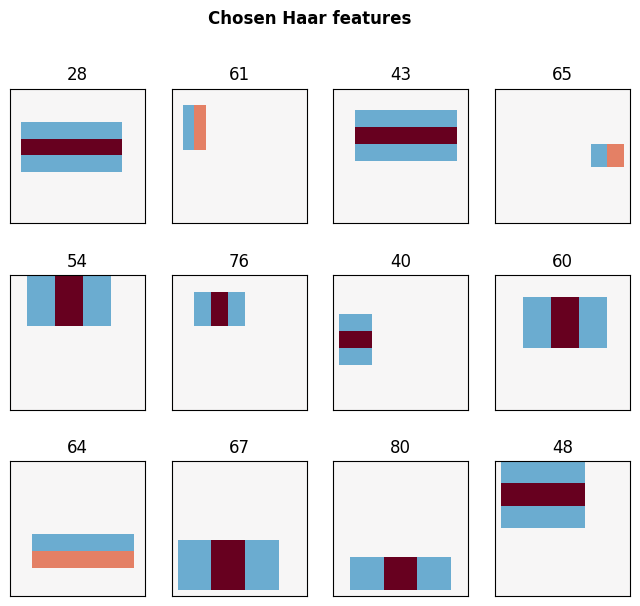

In [14]:
# Inputs:
# - haarFeatureMasks: The list of all generated Haar features
# - selectedIdx: The feature numbers of Haar features selected in the training
# - shuffle (False/True): Select in random order or as they were selected in training
# - N: The number of Haar features to plot

PlotSelectedHaarFeatures(haarFeatureMasks, selectedIdx = optParams[0], shuffle = False, N = 12)

#### **<span style="color:red">Question 5:</span>**
Choose one or two of these Haar-features and speculate what feature of a face this might detect.

#### **<span style="color:green">Answer:</span>**
- Haar feature number 38, This haar feature is in the middle of the image and the way the different colours represents, It seems like It might detect the Nose in a face, As the nose is a bit highcompare to othher part of the face, thus the dark colour, and then the same light colour at the both side of the Nose.
- Feature number 79: i think this feature will differentiate between the background and the face boundary, The light colour at the right side may detect that here is some depth, and thus might detect the face and background boundary.

---
### **5. Applying the model on real data**
Evaluating on the test data is, of course, a valid method to measure the objective performance of the model. However, if doesn't really give a feel for how useful the model would actually be in a real world application. This final test applies the model to every 24x24 pixel subimage in this famous photograph of the 1927 Solvay Conference on Physics, and highlights the most likely parts of the image to contain faces.

![](NotebookMaterials/Solvay.png "Famous photo from the 1927 Solvay Conference on Physics.")

Let's see how many of these famous faces your model can find!

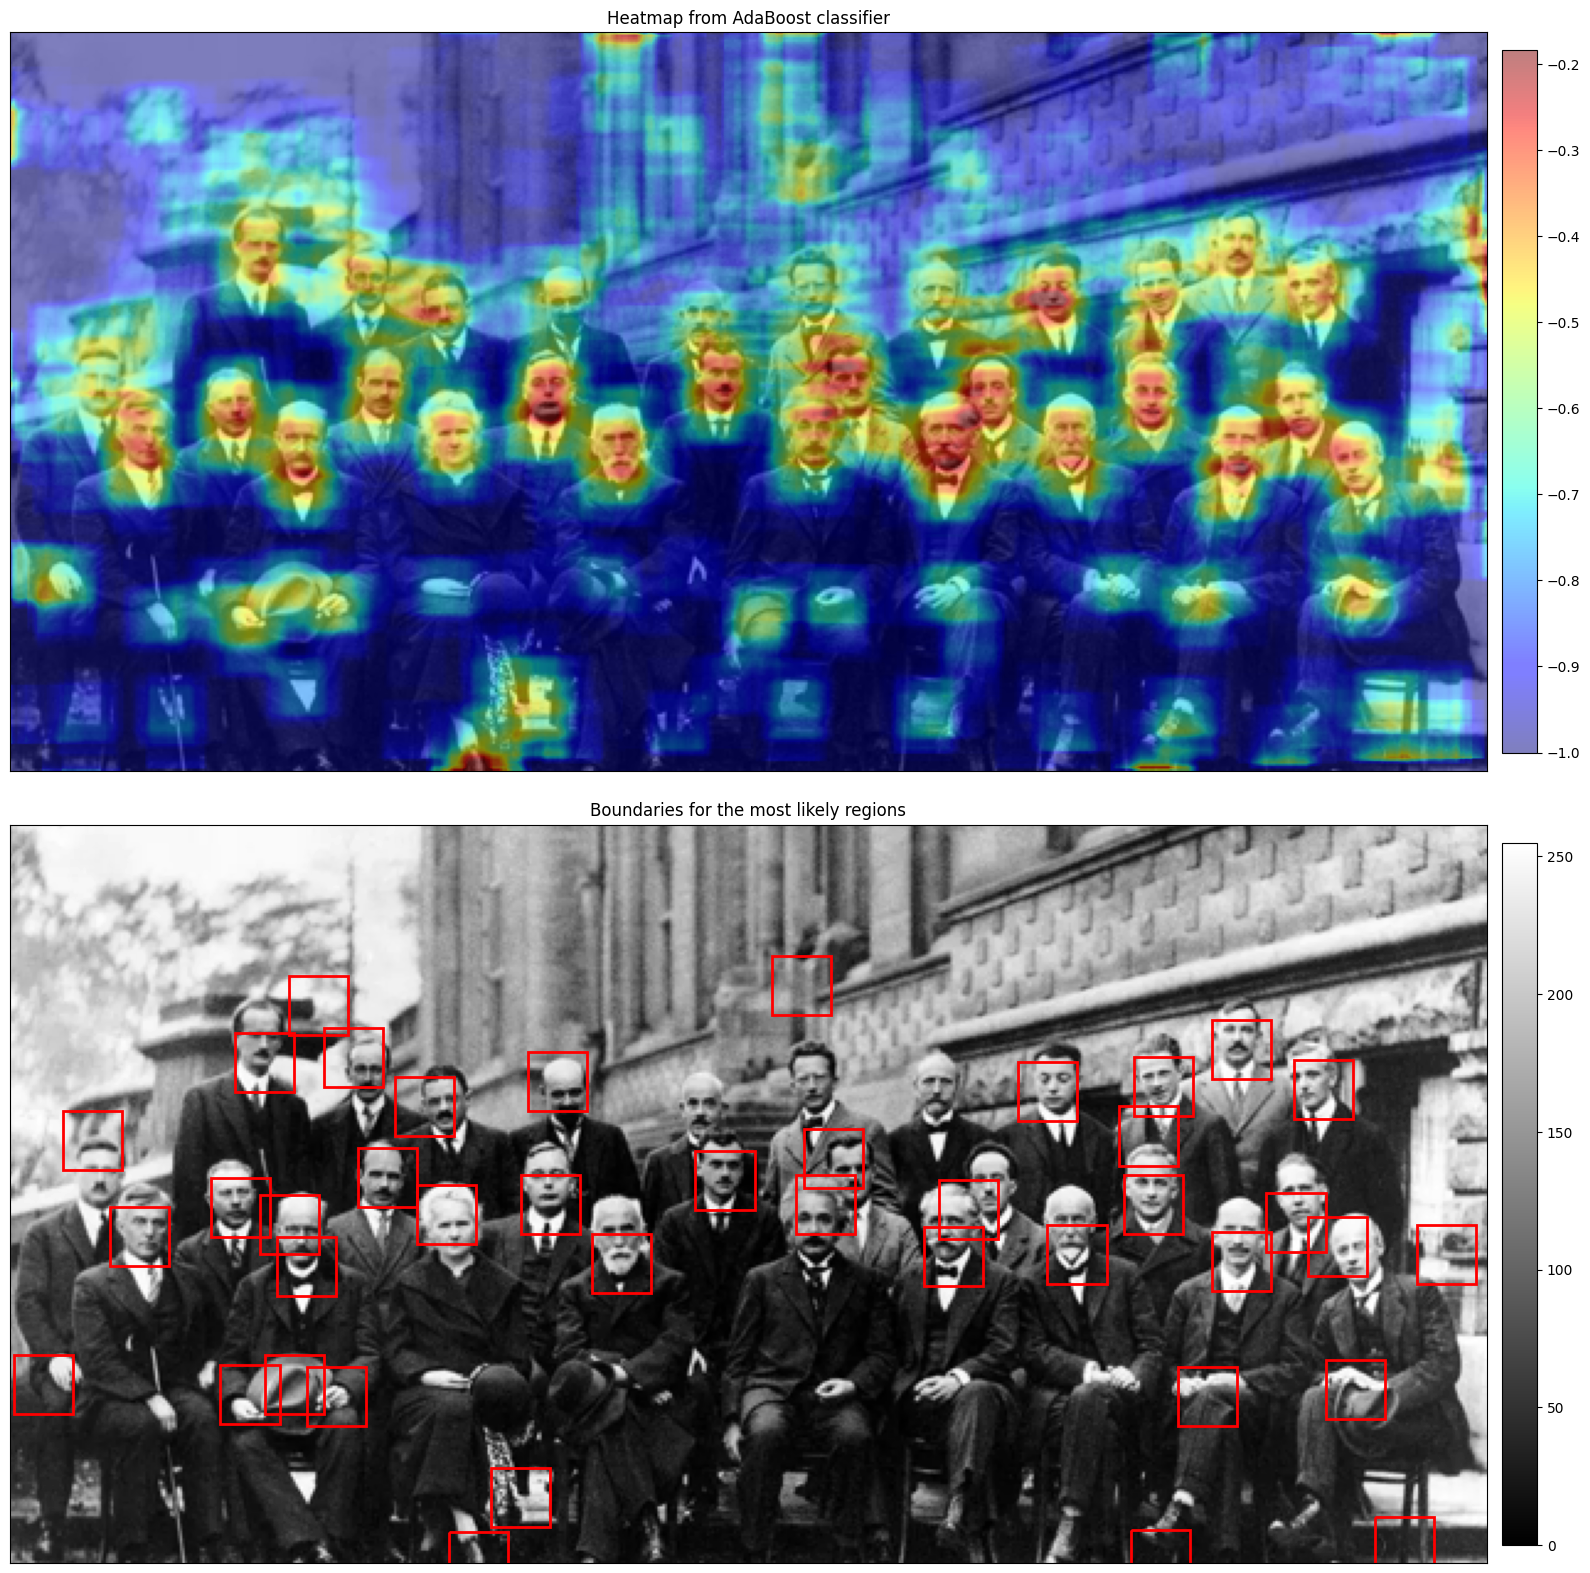

In [15]:
solvay = sio.loadmat('Data/solvay.mat')['X'].astype("float")
xSolvay = ExtractHaarFeatures(solvay, haarFeatureMasks)

cSolvay = StrongClassifier(optParams, xSolvay)

PlotSolvayHeatmap(cSolvay)

#### **<span style="color:red">Question 6:</span>**
Give a final discussion based on all the results. Do you think the model works well? Can you think of any way to improve the results?

#### **<span style="color:green">Answer:</span>**
As per the squares, I think the model is performing good, But as their is some overlaping between the different faces of these Scientists, It is not able to detect those, Even the positioning of the square are not correct in all th cases, I think we can traing the model with images of faces which do not hair, As the model is detecting some of them as wrong which do not have hairs. In this way we can even element the biases our classifier may have. Overall, the model is able to classify around 85% of the faces, Thus I believe it workes well.

In [ ]:
This repo contains implementation different lab assignment submitted to Linköping university as part of course TBMI26: Neural Network during my master's degree in Computer Science.